# Python AWIPS Data Access Framework

The [`python-awips`](http://www.github.com/Unidata/python-awips) package provides a Data Acccess Framework (DAF) for requesting data from a remote AWIPS II EDEX server.  

The [AWIPS II Python Stack](http://) installed via RPM contains the DAF, matplotlib, numpy, scipy, basemap, pint, shapely, and other packages. 

## Listing a Grid Inventory

In [173]:
from awips.dataaccess import DataAccessLayer

# Set host
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")

# Init data request
request = DataAccessLayer.newDataRequest()

# Set datatype
request.setDatatype("grid")

# Get a list of all available models
available_grids = DataAccessLayer.getAvailableLocationNames(request)

# Sort
available_grids.sort()

# Print
for grid in available_grids:
    print grid

AVN211
AVN225
DGEX
ECMF-Global
ECMF1
ECMF10
ECMF11
ECMF12
ECMF2
ECMF3
ECMF4
ECMF5
ECMF6
ECMF7
ECMF8
ECMF9
ETA
GFS
GFS40
GFSGuide
GFSLAMP5
HPCGuide
HPCqpfNDFD
HRRR
LAMP2p5
MRMS_1000
NAM12
NAM40
NCWF
NOHRSC-SNOW
NamDNG
NamDNG5
QPE-MSR
RAP13
RAP40
RTMA
RTMA5
URMA25
estofsPR
estofsUS


**LocationNames** is different for different plugins
- radar is icao
- satellite is sector


## Requesting a Grid

In [174]:
# Grid request
request.setLocationNames('RAP40')
request.setParameters("RH")
request.setLevels("850MB")

# Get available times
t = DataAccessLayer.getAvailableTimes(request)

# Select last available time [-1]
response = DataAccessLayer.getGridData(request, [t[0]])
data = response[0]
lon,lat = data.getLatLonCoords()

# Print info
print 'Time :', t[-1]
print 'Model:', data.getLocationName()
print 'Unit :', data.getUnit()
print 'Parm :', data.getParameter()

# Print data array
print data.getRawData().shape
print data.getRawData()
print "lat array =", lat
print "lon array =", lon


Time : 2016-02-23 15:00:00 (12)
Model: RAP40
Unit : %
Parm : RH
(151, 113)
[[ 93.05456543  93.05456543  87.05456543 ...,  73.05456543  72.05456543
   71.05456543]
 [ 70.05456543  70.05456543  67.05456543 ...,  69.05456543  46.05456924
   37.05456924]
 [ 40.05456924  56.05456924  68.05456543 ...,  51.05456924  73.05456543
   74.05456543]
 ..., 
 [ 65.05456543  62.05456924  63.05456924 ...,  67.05456543  65.05456543
   46.05456924]
 [ 48.05456924  59.05456924  62.05456924 ...,   4.05456877   5.05456877
    5.05456877]
 [  7.05456877   8.05456829  10.05456829 ...,  91.05456543  95.05456543
   95.05456543]]
lat array = [[ 54.24940109  54.35071945  54.45080566 ...,  57.9545517   57.91926193
   57.88272858]
 [ 57.84495163  57.80593109  57.76566696 ...,  58.07667542  58.08861542
   58.09931183]
 [ 58.10876846  58.11697769  58.12394714 ...,  56.40270996  56.46187973
   56.51980972]
 ..., 
 [ 19.93209648  19.89832115  19.86351395 ...,  20.054636    20.06362152
   20.07156372]
 [ 20.0784626   20

## Plotting a Grid using Basemap

Using **matplotlib**, **numpy**, and **basemap**:

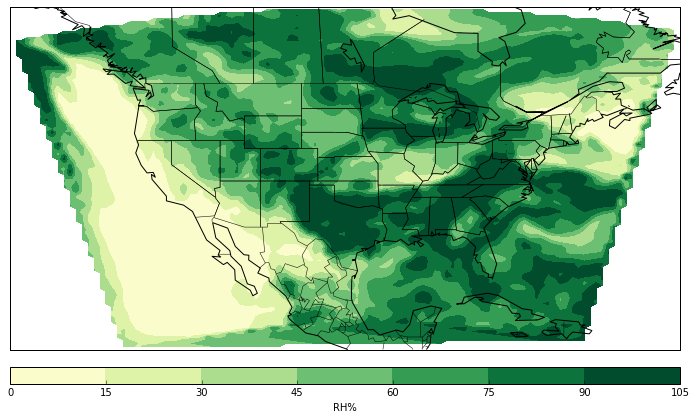

In [175]:
%matplotlib inline
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
from mpl_toolkits.basemap import Basemap, cm
import numpy as np
from numpy import linspace, transpose
from numpy import meshgrid

plt.figure(figsize=(12, 12), dpi=100)
lons,lats = data.getLatLonCoords()

map = Basemap(projection='cyl',
      resolution = 'c',
      llcrnrlon = lons.min(), llcrnrlat = lats.min(),
      urcrnrlon =lons.max(), urcrnrlat = lats.max()
)
map.drawcoastlines()
map.drawstates()
map.drawcountries()

# 
# We have to reproject our grid, see https://stackoverflow.com/questions/31822553/m
#
x = linspace(0, map.urcrnrx, data.getRawData().shape[1])
y = linspace(0, map.urcrnry, data.getRawData().shape[0])
xx, yy = meshgrid(x, y)
ngrid = len(x)
rlons = np.repeat(np.linspace(np.min(lons), np.max(lons), ngrid),
          ngrid).reshape(ngrid, ngrid)
rlats = np.repeat(np.linspace(np.min(lats), np.max(lats), ngrid),
          ngrid).reshape(ngrid, ngrid).T
tli = mtri.LinearTriInterpolator(mtri.Triangulation(lons.flatten(),
          lats.flatten()), data.getRawData().flatten())
rdata = tli(rlons, rlats)
cs = map.contourf(rlons, rlats, rdata, latlon=True, vmin=0, vmax=100, cmap='YlGn')

# add colorbar.
cbar = map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label(data.getParameter() + data.getUnit() )

# Show plot
plt.show()


or use `pcolormesh` instead of `contourf`

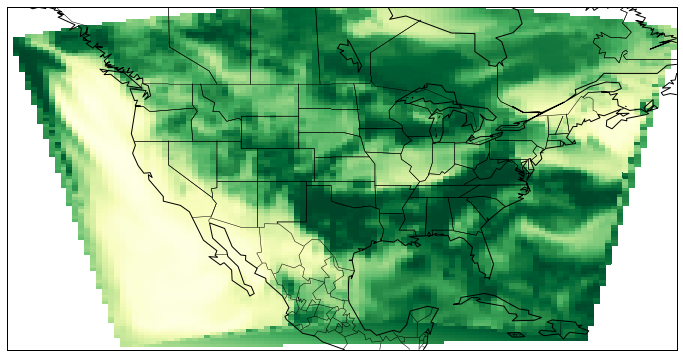

In [176]:
plt.figure(figsize=(12, 12), dpi=100)
map = Basemap(projection='cyl',
      resolution = 'c',
      llcrnrlon = lons.min(), llcrnrlat = lats.min(),
      urcrnrlon =lons.max(), urcrnrlat = lats.max()
)
map.drawcoastlines()
map.drawstates()
map.drawcountries()
cs = map.pcolormesh(rlons, rlats, rdata, latlon=True, vmin=0, vmax=100, cmap='YlGn')

## Plotting a Grid using Cartopy


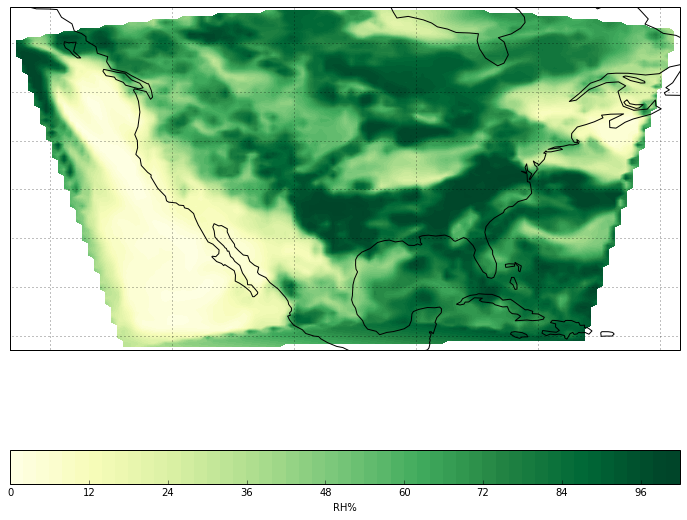

In [177]:
import os
import matplotlib.pyplot as plt
import numpy as np
import iris
import cartopy.crs as ccrs
from cartopy import config

lon,lat = data.getLatLonCoords()
plt.figure(figsize=(12, 12), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
cs = plt.contourf(rlons, rlats, rdata, 60, transform=ccrs.PlateCarree(), vmin=0, vmax=100, cmap='YlGn')
ax.coastlines()
ax.gridlines()

# add colorbar
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(data.getParameter() + data.getUnit() )
plt.show()

# Plotting a Sounding with MetPy

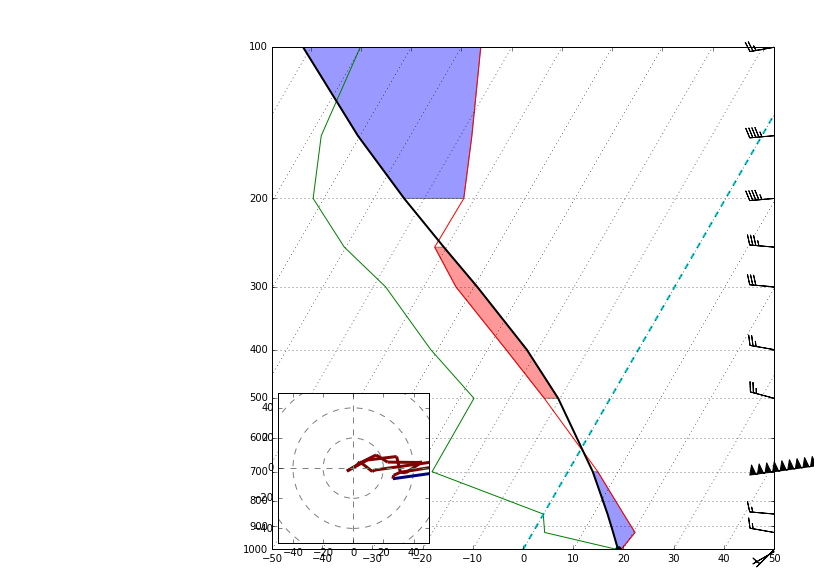

In [178]:
from metpy.calc import get_wind_components, lcl, dry_lapse, parcel_profile
from metpy.calc import tools
from metpy.plots import SkewT, Hodograph
from metpy.units import units, concatenate
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np

# Change default to be better for skew-T
plt.rcParams['figure.figsize'] = (9, 9)
#fig = plt.figure(figsize=(9, 9))

# Request BUFR UAIR
request.setDatatype("bufrua")
request.setParameters("tpMan","tdMan","prMan","htMan","wdMan","wsMan")
request.setLocationNames("72240")
datatimes = DataAccessLayer.getAvailableTimes(request)
response = DataAccessLayer.getGeometryData(request,times=datatimes[-1].validPeriod)

# Initialize data arrays
tpMan,tdMan,prMan,htMan,wdMan,wsMan = [],[],[],[],[],[]

# Build ordered arrays
for ob in response:
    tpMan.append(float(ob.getString("tpMan")))
    tdMan.append(float(ob.getString("tdMan")))
    prMan.append(float(ob.getString("prMan")))
    htMan.append(float(ob.getString("htMan")))
    wdMan.append(float(ob.getString("wdMan")))
    wsMan.append(float(ob.getString("wsMan")))

# Convert temps to C
T = np.array(tpMan)-273.15
Td = np.array(tdMan)-273.15
p = np.array(prMan)/100
height = np.array(htMan)
direc = np.array(wdMan)
spd = np.array(wsMan)
u, v = get_wind_components(spd, np.deg2rad(direc))
p = p * units.mbar
T = T * units.degC
Td = Td * units.degC
spd = spd * units.knot
direc = direc * units.deg

# Create a skewT plot
skew = SkewT()

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Calculate LCL height and plot as black dot
l = lcl(p[0], T[0], Td[0])
lcl_temp = dry_lapse(concatenate((p[0], l)), T[0])[-1].to('degC')
skew.plot(l, lcl_temp, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Example of coloring area between profiles
skew.ax.fill_betweenx(p, T, prof, where=T>=prof, facecolor='blue', alpha=0.4)
skew.ax.fill_betweenx(p, T, prof, where=T<prof, facecolor='red', alpha=0.4)

# An example of a slanted line at constant T -- in this case the 0 isotherm
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Draw hodograph
ax_hod = inset_axes(skew.ax, '30%', '30%', loc=3)
h = Hodograph(ax_hod, component_range=50.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, spd)

# Show the plot
plt.show()

# Surface Obs

In [243]:
request = DataAccessLayer.newDataRequest()
request.setDatatype("obs")
request.setLocationNames("KBJC")
datatimes = DataAccessLayer.getAvailableTimes(request)
time = datatimes[-1].validPeriod

# "presWeather","skyCover","skyLayerBase"
# are multi-dimensional... deal with these later
request.setParameters(
    "stationName",
    "timeObs",
    "wmoId",
    "autoStationType",
    "elevation",
    "reportType",
    "temperature",
    "tempFromTenths",
    "dewpoint",
    "dpFromTenths",
    "windDir",
    "windSpeed",
    "windGust",
    "visibility",
    "altimeter",
    "seaLevelPress",
    "pressChange3Hour",
    "pressChangeChar",
    "maxTemp24Hour",
    "minTemp24Hour",
    "precip1Hour",
    "precip3Hour",
    "precip6Hour",
    "precip24Hour"
)

response = DataAccessLayer.getGeometryData(request,times=time)
for ob in response:
    print "getParameters is",ob.getParameters()
    print len(ob.getParameters())
    #getParameters
    print ob.getString("stationName"), "from", ob.getDataTime().getRefTime()
    print "stationName is",ob.getString("stationName")
    print "timeObs is",ob.getString("timeObs")
    print "wmoId is",ob.getString("wmoId")
    print "autoStationType is",ob.getString("autoStationType")
    print "elevation is",ob.getString("elevation")
    print "reportType is",ob.getString("reportType")
    print "temperature is",ob.getString("temperature")
    print "tempFromTenths is",ob.getString("tempFromTenths")
    print "dewpoint is",ob.getString("dewpoint")
    print "dpFromTenths is",ob.getString("dpFromTenths")
    print "windDir is",ob.getString("windDir")
    print "windSpeed is",ob.getString("windSpeed")
    print "windGust is",ob.getString("windGust")
    print "visibility is",ob.getString("visibility")
    print "altimeter is",ob.getString("altimeter")
    print "seaLevelPress is",ob.getString("seaLevelPress")
    print "pressChange3Hour is",ob.getString("pressChange3Hour")
    print "pressChangeChar is",ob.getString("pressChangeChar")
    print "maxTemp24Hour is",ob.getString("maxTemp24Hour")
    print "minTemp24Hour is",ob.getString("minTemp24Hour")
    print "precip1Hour is",ob.getString("precip1Hour")
    print "precip3Hour is",ob.getString("precip3Hour")
    print "precip6Hour is",ob.getString("precip6Hour")
    print "precip24Hour is",ob.getString("precip24Hour")

getParameters is ['precip1Hour', 'tempFromTenths', 'precip24Hour', 'seaLevelPress', 'pressChange3Hour', 'temperature', 'dpFromTenths', 'reportType', 'pressChangeChar', 'elevation', 'precip3Hour', 'dewpoint', 'visibility', 'timeObs', 'maxTemp24Hour', 'stationName', 'altimeter', 'autoStationType', 'wmoId', 'windDir', 'windSpeed', 'minTemp24Hour', 'windGust', 'precip6Hour']
24
KBJC from Mar 14 16 17:46:00 GMT
stationName is KBJC
timeObs is 1457977560000
wmoId is -9999
autoStationType is 
elevation is 1729.0
reportType is METAR
temperature is 16.0
tempFromTenths is -9999.0
dewpoint is -7.0
dpFromTenths is -9999.0
windDir is 250.0
windSpeed is 32.0
windGust is 40.0
visibility is 70.0
altimeter is 29.6499996185
seaLevelPress is -9999.0
pressChange3Hour is -9999.0
pressChangeChar is 
maxTemp24Hour is -9999.0
minTemp24Hour is -9999.0
precip1Hour is -9999.0
precip3Hour is -9999.0
precip6Hour is -9999.0
precip24Hour is -9999.0


In [253]:
# multi-dimensional
request.setParameters("presWeather")
response = DataAccessLayer.getGeometryData(request,times=time)
for ob in response:
    print "getParameters is",ob.getParameters()
    print ob.getString("presWeather")
    for record in ob.getString("presWeather"):
        print record

getParameters is ['presWeather']

getParameters is ['presWeather']

getParameters is ['presWeather']

getParameters is ['presWeather']

getParameters is ['presWeather']



In [256]:
# multi-dimensional
request.setParameters("skyCover", "skyLayerBase")
response = DataAccessLayer.getGeometryData(request,times=time)
for ob in response:
    print "getParameters is",ob.getParameters()
    print ob.getString("skyCover")
    print ob.getString("skyLayerBase")

getParameters is ['skyCover', 'skyLayerBase']
FEW
8000.0
getParameters is ['skyCover', 'skyLayerBase']
SCT
15000.0
getParameters is ['skyCover', 'skyLayerBase']

-9999.0
getParameters is ['skyCover', 'skyLayerBase']

-9999.0
getParameters is ['skyCover', 'skyLayerBase']

-9999.0
getParameters is ['skyCover', 'skyLayerBase']

-9999.0
